In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-06-19 16:43:07--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.05s   

2024-06-19 16:43:08 (4.41 MB/s) - ‘names.txt’ saved [228145/228145]



In [6]:
words = open("names.txt", "r").read().splitlines()
stoi = {c:i+1 for i, c in enumerate(sorted(list(set(''.join(words)))))}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [7]:
block_size = 3

def build_dataset(words):
  block_size = 3
  X, y = [], []
  for w in words:
    context = [0] * block_size
    for char in w + '.':
      ix = stoi[char]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  y = torch.tensor(y)
  print(X.shape, y.shape)
  return X, y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, ytr = build_dataset(words[:n1])
Xdev, ydev = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
block_size = 3
X, y = [], []

for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)

In [9]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)

C = torch.randn(size=(vocab_size, n_embd), generator=g)
W1 = torch.randn(size=(n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(size=(n_hidden,), generator=g) * 0.01
W2 = torch.randn(size=(n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(size=(vocab_size,), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [ ]:
epochs = 100000
batch_size = 32
lossi = []


for epoch in range(epochs):
  ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]
  embed = C[Xb]
  hpreact = embed.view(embed.shape[0], -1) @ W1 + b1
  hpreact =bngain *  (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.item())

  if epoch % 10000 == 0:
    print(f'{epoch:7d}/{epochs:7d}: {loss.item():.4f}')
print(loss)


      0/ 100000: 3.2971
  10000/ 100000: 2.3971
  20000/ 100000: 2.0381
  30000/ 100000: 2.0903
  40000/ 100000: 2.4343
  50000/ 100000: 1.6299
  60000/ 100000: 1.7833
  70000/ 100000: 1.7086
  80000/ 100000: 2.0821


In [54]:
embed = C[Xtr]
hpreact = embed.view(embed.shape[0], -1) @ W1 + b1
hpreact =bngain *  (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ytr)
loss

tensor(2.1360, grad_fn=<NllLossBackward0>)

(array([ 18.,  15.,  48.,  66.,  77.,  95.,  88., 126., 125., 143., 129.,
        156., 128., 142., 119., 138., 160., 154., 152., 162., 160., 187.,
        184., 205., 158., 174., 170., 179., 165., 167., 192., 146., 155.,
        162., 162., 153., 155., 161., 146., 132., 137., 125., 138., 104.,
         97.,  73.,  76.,  46.,  39.,  11.]),
 array([-0.97110438, -0.93189077, -0.89267716, -0.85346354, -0.81424993,
        -0.77503632, -0.7358227 , -0.69660909, -0.65739548, -0.61818186,
        -0.57896825, -0.53975464, -0.50054102, -0.46132741, -0.4221138 ,
        -0.38290018, -0.34368657, -0.30447296, -0.26525934, -0.22604573,
        -0.18683212, -0.1476185 , -0.10840489, -0.06919128, -0.02997766,
         0.00923595,  0.04844956,  0.08766317,  0.12687679,  0.1660904 ,
         0.20530401,  0.24451763,  0.28373124,  0.32294485,  0.36215847,
         0.40137208,  0.44058569,  0.47979931,  0.51901292,  0.55822653,
         0.59744015,  0.63665376,  0.67586737,  0.71508099,  0.7542946 ,
 

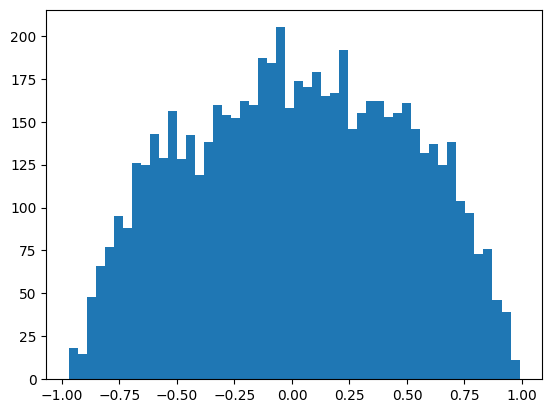

In [43]:
plt.hist(h.view(-1).tolist(), 50)

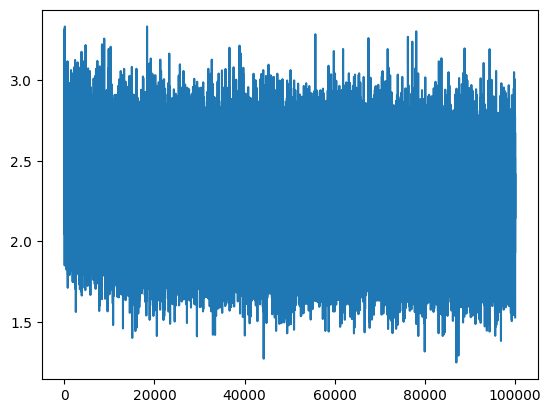

In [37]:
plt.plot(lossi)

In [38]:
# sample from the model

g = torch.Generator().manual_seed(42)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))


yassyah.
evann.
elle.
khaleg.
aya.
tryckenneen.
ema.
elyn.
jose.
abrie.
anas.
atourashvyn.
peg.
evanezilen.
jamiri.
emina.
ell.
kaylyn.
keona.
reen.


tensor(0.0107) tensor(1.0046)
tensor(0.0045) tensor(1.0079)


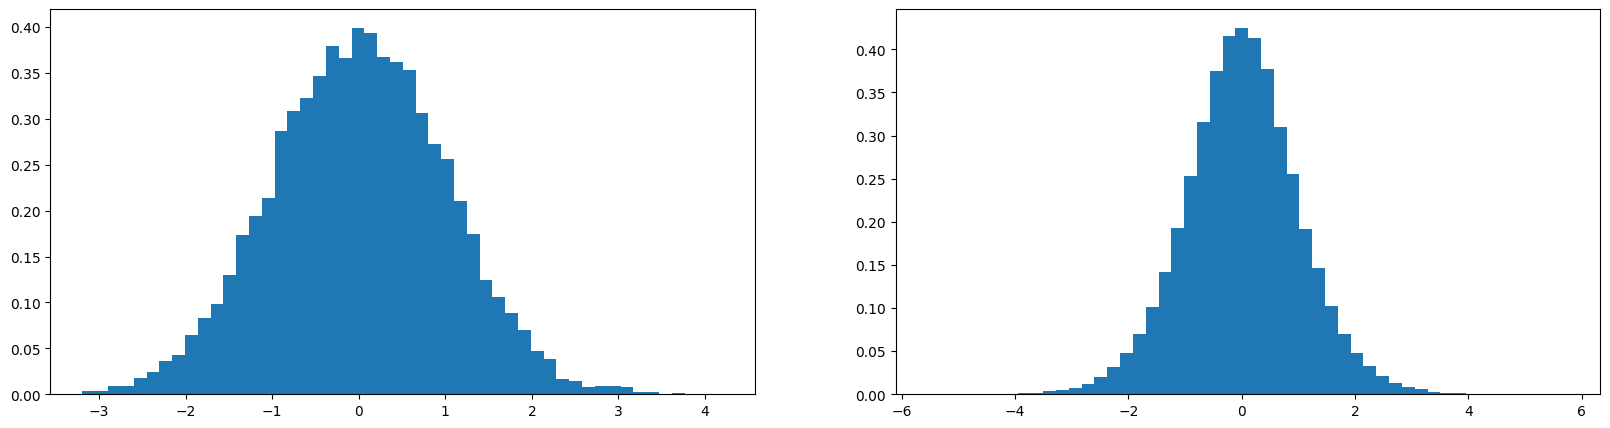

In [48]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [1]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn(size=(fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


In [3]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True, unbiased=True)

    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [22]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden),BatchNorm1d(n_hidden), tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

47551


In [23]:
epochs = 100000
batch_size = 32
lossi = []

for i in range(epochs):
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, yb = Xtr[ix], ytr[ix]
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, yb)

  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i < 50000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{epochs:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 100000:3.2998


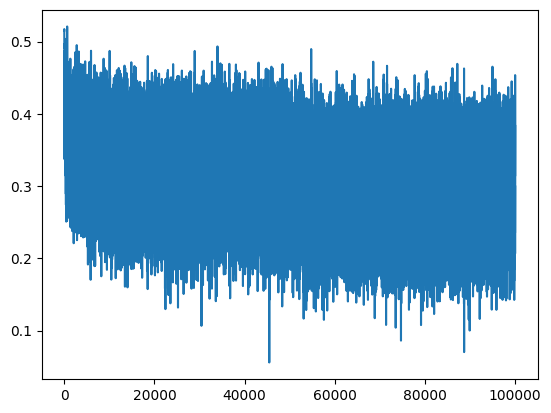

In [18]:
plt.plot(lossi)